# Anti-cancer activity prediction



✔️ Problem Formulation:
* Define the problem. What is the input? What is the output? What data mining function is required? What could be the challenges? What is the impact? What is an ideal solution?

## ✔️ Answer Questions

### 🌈Based on the provided template, describe the format of the input file (sdf file).

**The SDF file format stands for Structure Data File, and it contains information about a chemical compound. It stores details about the position of individual atoms in the molecule and their connections. The SDF file is used to represent the 3D structure of the molecule. In this format, different molecules are separated by a special delimiter, which is the '\$' symbol.**

### 🌈What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?



**Nodes**: The input tensor contains the node features of the chemical compound represented in tokenized form. Each batch has a shape of (batch_size * max_len_nodes), where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes with padding.

**Edge**: The input tensor contains information about the relations between atoms in the chemical compound. Each batch has a shape of (sum_of_all_edges, 2), where sum_of_all_edges represents the sum of edges for all samples in the batch.

**node2graph**: The input tensor is used for segmented mean and contains information about segmented ids. Each batch has a shape of (batch_size * max_len_nodes).

### 🌈For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?



- The gnn_out tensor is the output of the GNN (Graph Neural Network) model and has the shape (batch_size, num_classes).

    - The first dimension batch_size represents the number of samples in the batch.
    - The second dimension num_classes represents the number of output classes of the model.
- The avg tensor is the output of the torch.mean function and has the shape (batch_size,).

    - The first dimension batch_size represents the number of samples in the batch.
    - This tensor contains the mean value of the gnn_out tensor for each sample in the batch.

### 🌈What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?



segment_mean and tf.reduce_mean are both functions in TensorFlow that can be used to calculate the mean of input data. The main difference between them is that segment_mean calculates the mean of segments or partitions of the input data, while tf.reduce_mean calculates the mean of the entire input data.

For each dim of pred:

pred is the output tensor of the neural network model and its dimensions represent:

- The first dimension represents the number of samples in the batch.
- The second dimension represents the number of classes in the classification problem.
- The remaining dimensions represent the size of the output tensor for each sample and each class. The meaning of these dimensions would depend on the architecture and design of the neural network model.

### 🌈What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?



The motivation behind using multiple GCN (Graph Convolutional Network) layers is to allow the model to learn more complex and abstract representations of the graph. Each layer can capture different levels of abstraction, with higher layers learning more complex patterns based on the output of lower layers. This hierarchical approach can improve the model's performance on more challenging graph-based tasks.

the layers were used in the template are 4 

______________________________________________________________________________________

## Code

In [114]:
!pip install --quiet networkx # Install the NetworkX library
!pip install --quiet tf2_gnn # Install the tf2_gnn package

In [115]:
# Import the necessary Python libraries
import numpy as np       # Numerical computing with Python
import pandas as pd      # Data manipulation and analysis
import matplotlib.pyplot as plt # Plotting library

import tensorflow as tf  # Open source machine learning framework
from tensorflow import keras
from tensorflow.keras import Input, Model # Keras functional API
from tensorflow.keras.optimizers import Adam # Adam optimizer
from tensorflow.keras.layers import Embedding, Dense # Keras layers for neural networks
from tensorflow.keras.preprocessing.text import Tokenizer # Tokenizing text data
from tensorflow.keras.preprocessing.sequence import pad_sequences # Padding sequences of variable length
from tensorflow.math import segment_mean # Segment mean function from TensorFlow math module

import sklearn
from sklearn.utils import resample # Import the resample function from scikit-learn
from sklearn.model_selection import train_test_split # Splitting data into training and testing sets

import math              # Mathematical functions
import random            # Random number generation
import collections       # Container datatypes
import networkx as nx    # Network analysis and visualization
from matplotlib import cm # Color maps for visualizations

from tf2_gnn.layers.gnn import GNN, GNNInput # Import the GNN and GNNInput classes from the tf2_gnn.layers.gnn module

from tqdm.notebook import tqdm # Progress bars for loops


## Reading Data and Exploration

In [116]:
# Define a function to read SDF files and return a list of parsed samples
def read_sdf(file):
    # Open the file in read mode and read its content
    with open(file, 'r') as rf:
        content = rf.read()
        # Split the content into individual samples separated by '$$$$'
        samples = content.split('$$$$')

    # Define a function to parse an individual sample
    def parse_sample(s):
        # Split the sample into individual lines
        lines = s.splitlines()
        # Initialize empty lists for nodes and links, and set label to 0
        nodes = []
        links = []
        label = 0

        # Loop through each line in the sample
        for l in lines:
            # If the line contains '1.0', set the label to 1
            if l.strip() == '1.0':
                label = 1
            # If the line contains '-1.0', set the label to 0
            if l.strip() == '-1.0':
                label = 0
            # If the line starts with four spaces, it contains a node
            if l.startswith('    '):
                # Split the line into its components
                feature = l.split()
                # Extract the node ID and add it to the list of nodes
                node = feature[3]
                nodes.append(node)
            # If the line starts with a space, it contains an edge
            elif l.startswith(' '):
                # Split the line into its components
                lnk = l.split()
                # Check that the source node for the edge is valid
                if int(lnk[0]) - 1 < len(nodes):
                    # Add the edge to the list of links, converting from 1-based to 0-based indexing
                    links.append((
                        int(lnk[0])-1,
                        int(lnk[1])-1,
                    ))

        # Return the list of nodes, the list of links, and the label
        return nodes, np.array(links), label

    # Parse each sample in the list of samples, but only keep samples with non-empty nodes
    # Use tqdm to display a progress bar
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]


In [117]:
from sklearn.model_selection import train_test_split
training_set = read_sdf('/kaggle/input/cisc873-dm-w23-a6/train.sdf')
testing_set  = read_sdf('/kaggle/input/cisc873-dm-w23-a6/test_x.sdf')
print('length of Tr_df:', len(training_set) ,'length of Ts_df:',len(testing_set))
print('length of Tr_df[0]:', len(training_set[0]),'length of Ts_df[0]:',len(testing_set[0]))
training_set, validation_set = train_test_split(training_set, test_size=0.2,)

  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

length of Tr_df: 25024 length of Ts_df: 12326
length of Tr_df[0]: 3 length of Ts_df[0]: 3


In [118]:
print(training_set[1])

(['O', 'O', 'O', 'O', 'O', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  9],
       [ 1, 10],
       [ 2, 12],
       [ 3,  6],
       [ 4,  6],
       [ 5,  7],
       [ 5, 10],
       [ 5, 13],
       [ 6, 19],
       [ 7,  8],
       [ 7, 11],
       [ 8,  9],
       [ 8, 12],
       [ 9, 10],
       [11, 15],
       [11, 16],
       [12, 14],
       [13, 17],
       [13, 18],
       [14, 24],
       [14, 25],
       [14, 26],
       [15, 20],
       [16, 21],
       [17, 22],
       [18, 23],
       [19, 20],
       [19, 21],
       [22, 27],
       [23, 27],
       [27, 28]]), 0)


- This code creates a list of labels by iterating over each sample in the training_set.
- It then uses the collections.
- Counter function to count the number of occurrences of each label. 
- Finally, it loops over the label counts and prints them out.

In [119]:
labels = [sample[2] for sample in training_set] # Extracting the labels from the training set
label_counts = collections.Counter(labels) # Counting the frequency of each label
for label, count in label_counts.items(): # Iterate through each label and its count
    print(f"Label {label}: {count} samples") # Printing the label and the number of samples with that label


Label 0: 19041 samples
Label 1: 978 samples


#### From above result, we have unbalanced data, we need more sample for label 1

## Visualizing a Sample

In [120]:
colors = cm.YlGnBu(np.linspace(0, 1, 30)) # Create a color map with 30 colors from the YlGnBu colormap

In [121]:

# Define a function that takes a sample as input and visualizes it as a graph
def visualize(sample):
    # Create an empty graph
    G = nx.Graph()
    # Extract the list of nodes and list of edges from the input sample
    nodes = sample[0]
    edges = sample[1]
    # Create a dictionary to associate labels with nodes
    labeldict = {}
    # Create a list to assign a color to each node
    node_color = []
    # Iterate over the list of nodes
    for i, n in enumerate(nodes):
        # Add the node to the graph
        G.add_node(i)
        # Associate the label with the node index in the labeldict dictionary
        labeldict[i] = n
        # Assign a color to the node based on a hash of its label
        node_color.append(colors[hash(n) % len(colors)])
    # Iterate over the list of edges
    for e in edges:
        # Add the edge to the graph
        G.add_edge(e[0], e[1])
    # Draw the graph
    nx.draw(G, labels=labeldict, with_labels=True, node_color=node_color)
    # Display the visualization
    plt.show()
    # Return the graph object
    return G


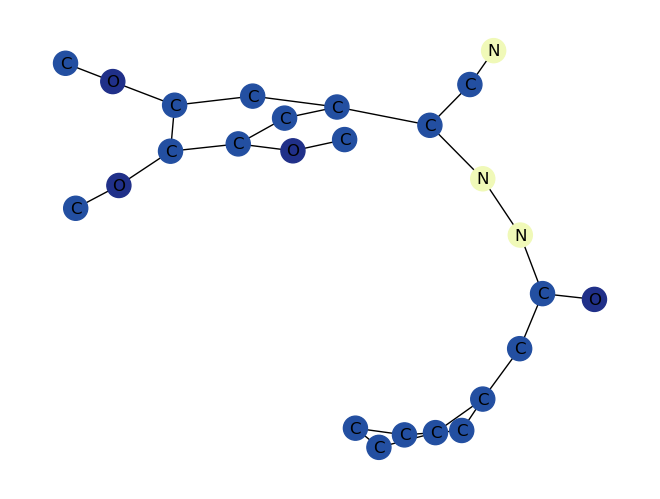

In [122]:
visualize(training_set[5]) #visualize sample

## Preprocessing 

In [149]:
# Set the maximum vocabulary size to 500 and the maximum sequence length to 100
max_vocab = 500
max_len = 100

# Extract all nodes from the training set and store them in a list called all_nodes
all_nodes = [s[0] for s in training_set]

# Create a tokenizer object with the specified maximum vocabulary size
tokenizer = Tokenizer(num_words=max_vocab)

# Fit the tokenizer on the list of nodes to create the vocabulary
tokenizer.fit_on_texts(all_nodes)


In [150]:
# Set the random seed to ensure reproducibility
random.seed(0)

# Define a function to prepare a batch of samples for training
def prepare_single_batch(samples):
    # Extract the node labels from the samples and convert them to sequences of integers
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    
    # Pad the sequences to ensure they all have the same length
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    
    # Get the maximum node length for this batch
    max_nodes_len = np.shape(sample_nodes)[1]
    
    # Concatenate the edge lists for each sample into a single list
    edges = [s[1] + i * max_nodes_len for i, s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    
    # Create a mapping from node index to sample index for each node in the batch
    node_to_graph = [[i] * max_nodes_len for i in range(len(samples))]
    
    # Flatten the node and edge arrays
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)
    node_to_graph = np.reshape(node_to_graph, -1)
    
    # Return the prepared batch as a dictionary of inputs and output labels
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2graph': node_to_graph,
    }, np.array([s[2] for s in samples])


* This code defines a function gen_batch that takes a dataset, batch size, and other parameters as input, and generates batches of prepared samples for training the model.

* The function first enters an infinite loop with a while True statement. Within this loop, the function converts the dataset to a list and shuffles it (if shuffle=True).

* The function then gets the length of the dataset and loops over it in batches of size batch_size, using the range function. For each batch, the function gets the current batch of samples and prepares it for training using the prepare_single_batch function. The prepared batch is then yielded using the yield statement.

* After processing the entire dataset once, the function checks if repeat=False. If so, it breaks out of the infinite loop and ends the function. If not, it continues looping indefinitely, shuffling the dataset each time.

In [151]:

# Define a generator function that takes a dataset, batch size, repeat flag, and shuffle flag as input
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    
    # Create an infinite loop that yields batches of data until the repeat flag is False
    while True:
        
        # Convert the dataset to a list and shuffle it if the shuffle flag is True
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        
        # Get the length of the dataset
        l = len(dataset)
        
        # Iterate through the dataset in batches of size batch_size
        for ndx in range(0, l, batch_size):
            
            # Get the batch of samples for the current iteration
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            
            # Prepare the batch of data and labels using a function called prepare_single_batch
            batch_data, batch_labels = prepare_single_batch(batch_samples)
            
            # Yield the batch of data and labels
            yield batch_data, batch_labels
        
        # If the repeat flag is False, exit the infinite loop
        if not repeat:
            break


## Model Structure  

#### Virtualization Fun

In [152]:
def plot_model_history(history):

  # generate a figure containing 3 plots displayed horizontally
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,7))
  fig.suptitle('Model Results')
  
  #first plot
  # first we display the training accuracy in red color VS. the validation accuracy in blue color through the epochs
  ax1.plot(history.history['auc'], 'r')
  ax1.plot(history.history['val_auc'], 'b')
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epochs')
  ax1.legend(['tr_price_acc', 'val_price_acc'])
  ax1.grid()

  #second plot
  # on this axis, we plot the training loss in red color VS. the validation loss in blue color through the epochs
  ax2.plot(history.history['loss'], 'r')
  ax2.plot(history.history['val_loss'], 'b')
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(['tr_loss', 'val_loss'])
  ax2.grid()

# display the figure
  plt.show() 

4- ✔️ Model Tuning and Documentation

In [157]:
#defines a function named GNN_model that takes in six parameters: n, condition, dropout_ratio, hidden_layers, mode, and par.
def GNN_model(n, condition, dropout_ratio, hidden_layers, mode, par):
# Define input layers for node features, edge indices and node-to-graph mapping respectively
    data = keras.Input(batch_shape=(None,))
    edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
    node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

    # Embed the input data using tokenization
    embeded = Embedding(tokenizer.num_words, 100)(data)

    # Compute the number of graphs (i.e., number of samples)
    num_graph = tf.reduce_max(node2graph) + 1

# Define the input to the GNN layer using GNNInput, which specifies node features, edge indices, node-to-graph mapping and number of graphs
    gnn_input = GNNInput(
        node_features=embeded,
        adjacency_lists=(edge,),
        node_to_graph_map=node2graph,
        num_graphs=num_graph,
    )

    # Set hyperparameters for the GNN layer
    params = GNN.get_default_hyperparameters()
    params["hidden_dim"] = n  # Hidden dimension of the GNN layer
    params["num_heads"] = 8  # Number of attention heads in the GNN layer
    params["use_inter_layer_layernorm"] = condition  # Use inter-layer layer normalization
    params["layer_input_dropout_rate"] = dropout_ratio  # Dropout rate for the input to each layer
    params['num_aggr_MLP_hidden_layers'] = hidden_layers  # Number of hidden layers in the MLP used for message aggregation
    params["global_exchange_mode"] = mode  # Global exchange mode
    params['message_calculation_class'] = par  # Message calculation method

    # Create the GNN layer and apply it to the input to obtain graph-level embeddings
    gnn_layer = GNN(params)        
    gnn_out = gnn_layer(gnn_input) 

    # Computes the mean of the graph-level embeddings, where each graph is identified by its corresponding value in node2graph.
    avg = segment_mean(
        data=gnn_out,
        segment_ids=node2graph
    )

    # Define the fully connected layers for classification
    l1 = Dense(64, activation='relu')(avg)
    l2 = Dense(64, activation='relu')(l1)
    pred = Dense(1, activation='sigmoid')(l2)

    # Define the model with inputs and outputs
    model = Model(
        inputs={
            'data': data,
            'edges': edge,
            'node2graph': node2graph,
        },
        outputs=pred
    )

    # Return the model
    return model


* This function will print the model summary, compile the model with the specified loss and metrics, train the model, generate predictions on the testing set, and save the predictions to a CSV file. 
* It then reads the CSV file and returns the model summary (as a string), the contents of the CSV file (as a string), and the history object. 
* Note that the history object will contain information about the training and validation losses and metrics, which can be passed to the plot_model_history function for visualization.

In [161]:

# define a function to fit, predict and save a model
def Fit_Pred_Save(model, Optimizer, Batch_size, epc, Num_Trial):
    # set the batch size
    batch_size = Batch_size
    # calculate the number of batches needed for training and validation sets
    num_batchs = math.ceil(len(training_set) / batch_size)
    num_batchs_validation = math.ceil(len(validation_set) / batch_size)

    # compile the model using the specified optimizer, loss function and metric
    model.compile(optimizer=Optimizer, loss='BinaryCrossentropy', metrics=['AUC'])

    # fit the model using the training set, validation set and specified batch size
    history = model.fit(
        gen_batch(training_set, batch_size=batch_size, repeat=True),
        steps_per_epoch=num_batchs,
        epochs=epc,
        validation_data=gen_batch(validation_set, batch_size=16, repeat=True),
        validation_steps=num_batchs_validation,
    )
    
    # predict the labels of the test set using the trained model
    y_pred = model.predict(gen_batch(testing_set, batch_size=16, shuffle=False))
    y_pred = np.reshape(y_pred, -1)

    # create a submission dataframe with predicted labels and save it to a csv file
    submission = pd.DataFrame({'label': y_pred})
    submission.index.name = 'id'
    submission.to_csv(f'sample_submission_{Num_Trial}.csv')

    # read the saved csv file and store its contents in a variable
    with open(f'sample_submission_{Num_Trial}.csv', 'r') as f:
        csv_file = f.read()
    
    # return the model summary, contents of the saved csv file and training history
    return model.summary(), csv_file, history


# Trial 1(No Upsampling)

- The GNN_model function is called with six arguments that configure the graph neural network.
- The model has 32-dimensional node embeddings, no condition-aware message passing, no dropout, 12 hidden layers, a GRU RNN, and an R-GCN layer.

In [162]:
Model_1=GNN_model(32,False,0,12,'gru','rgcn')

In [163]:
summary, csv_file, history = Fit_Pred_Save(Model_1,'Adam',16,30,1)

Epoch 1/30
1252/1252 [==============================] - 21s 13ms/step - loss: 0.2058 - auc: 0.5920 - val_loss: 0.1788 - val_auc: 0.7054
Epoch 2/30
1252/1252 [==============================] - 16s 13ms/step - loss: 0.1809 - auc: 0.6795 - val_loss: 0.1786 - val_auc: 0.6992
Epoch 3/30
1252/1252 [==============================] - 15s 12ms/step - loss: 0.1783 - auc: 0.7055 - val_loss: 0.1741 - val_auc: 0.7280
Epoch 4/30
1252/1252 [==============================] - 17s 13ms/step - loss: 0.1758 - auc: 0.7230 - val_loss: 0.1773 - val_auc: 0.7217
Epoch 5/30
1252/1252 [==============================] - 16s 13ms/step - loss: 0.1748 - auc: 0.7247 - val_loss: 0.1737 - val_auc: 0.7382
Epoch 6/30
1252/1252 [==============================] - 17s 13ms/step - loss: 0.1734 - auc: 0.7341 - val_loss: 0.1737 - val_auc: 0.7528
Epoch 7/30
1252/1252 [==============================] - 15s 12ms/step - loss: 0.1723 - auc: 0.7467 - val_loss: 0.1701 - val_auc: 0.7442
Epoch 8/30
1252/1252 [==========================

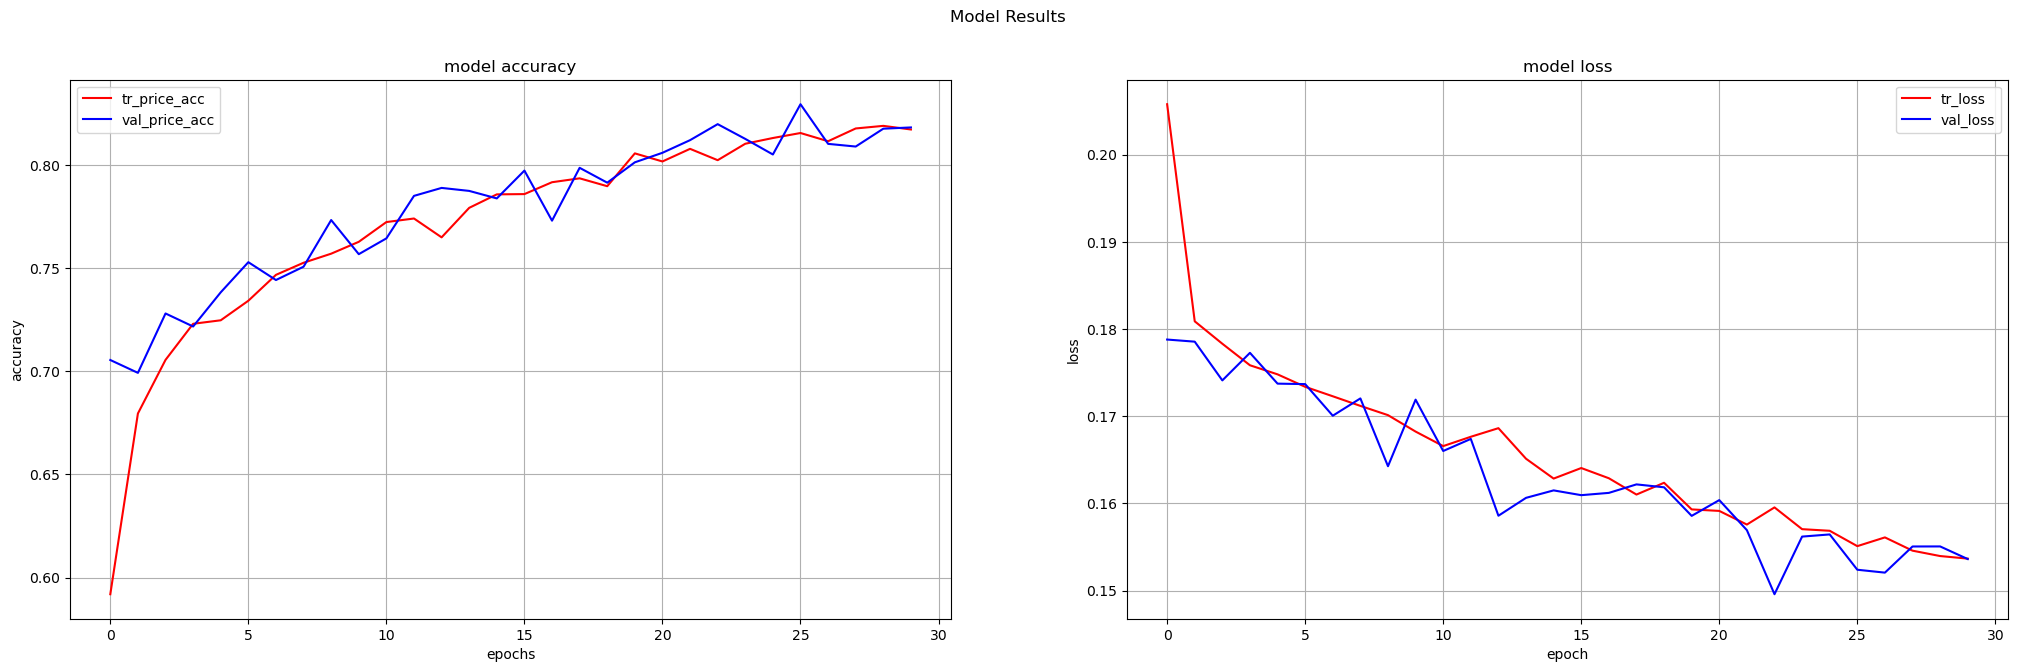

In [164]:
plot_model_history(history)

# Trial 2(No Upsampling)

- The GNN_model function is called with six arguments that configure the graph neural network.
- The model has 32-dimensional node embeddings, no condition-aware message passing, no dropout, 12 hidden layers, a GRU RNN, and a GGNN layer.

In [165]:
Model_2=GNN_model(32,False,0,12,'gru','ggnn')

In [166]:
summary, csv_file, history = Fit_Pred_Save(Model_2,'Adam',16,30,2)

Epoch 1/30
1252/1252 [==============================] - 27s 16ms/step - loss: 0.1972 - auc: 0.6035 - val_loss: 0.1833 - val_auc: 0.6730
Epoch 2/30
1252/1252 [==============================] - 18s 14ms/step - loss: 0.1830 - auc: 0.6653 - val_loss: 0.1790 - val_auc: 0.7172
Epoch 3/30
1252/1252 [==============================] - 20s 16ms/step - loss: 0.1777 - auc: 0.6955 - val_loss: 0.1736 - val_auc: 0.7327
Epoch 4/30
1252/1252 [==============================] - 19s 16ms/step - loss: 0.1756 - auc: 0.7126 - val_loss: 0.1696 - val_auc: 0.7590
Epoch 5/30
1252/1252 [==============================] - 19s 15ms/step - loss: 0.1728 - auc: 0.7352 - val_loss: 0.1746 - val_auc: 0.7569
Epoch 6/30
1252/1252 [==============================] - 19s 15ms/step - loss: 0.1692 - auc: 0.7515 - val_loss: 0.1702 - val_auc: 0.7498
Epoch 7/30
1252/1252 [==============================] - 19s 15ms/step - loss: 0.1686 - auc: 0.7522 - val_loss: 0.1699 - val_auc: 0.7724
Epoch 8/30
1252/1252 [==========================

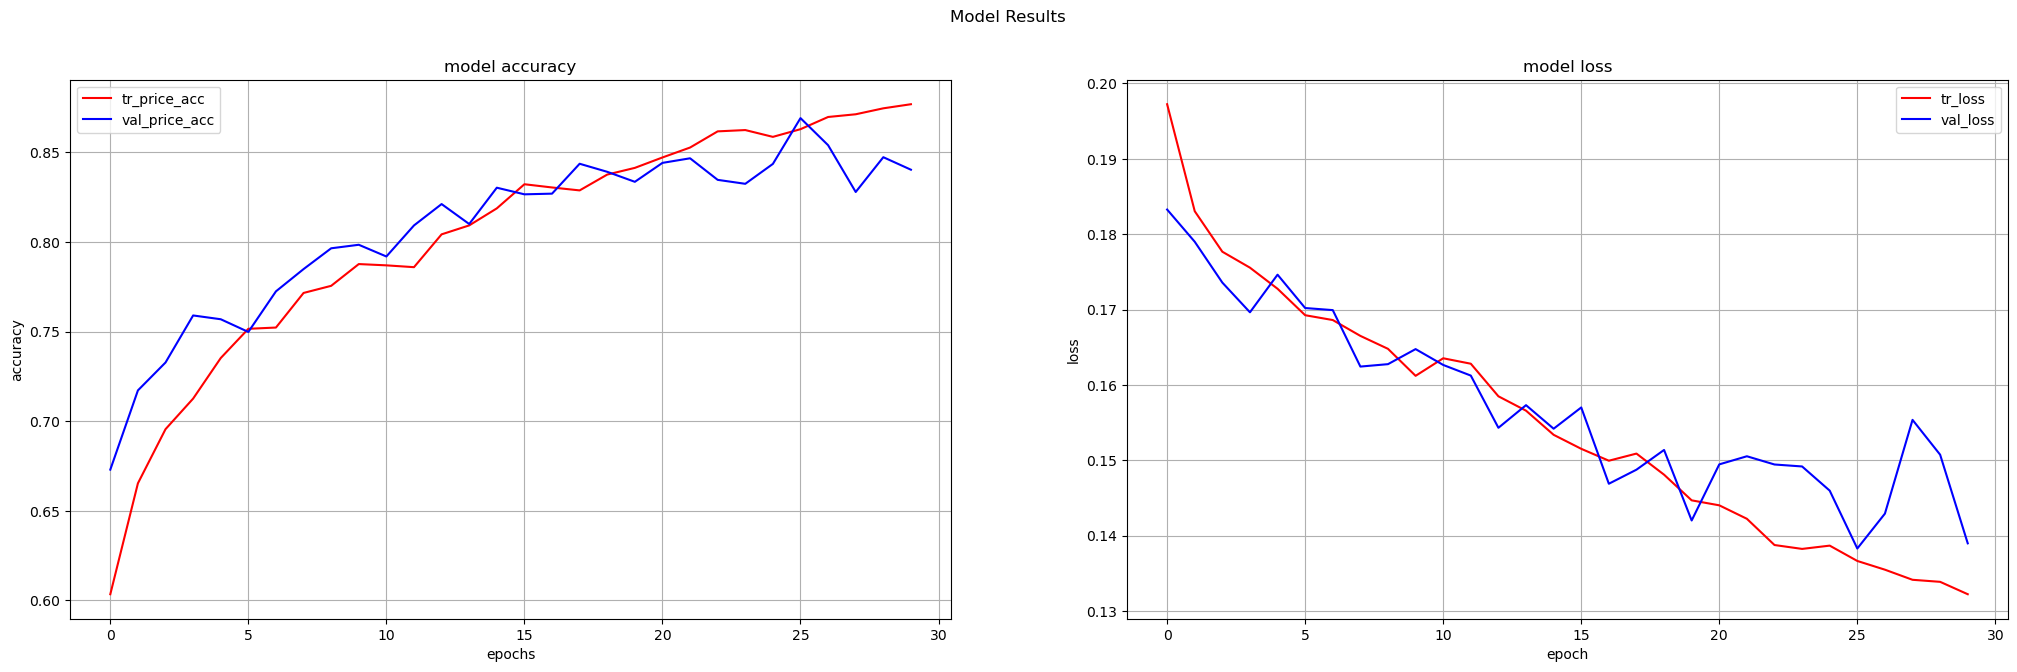

In [167]:
plot_model_history(history)

**Observation_2**
* First, I used Gated Graph Neural Networks mechanism(GGNN).

*  I used Adam optimizer I noticed that accuracy was increased clearly

* The batch size 16 and epoch 30

* I get Score: 0.86 /Public score: 0.85863

# Trial 3(No Upsampling)

- the model will have 32-dimensional node embeddings, no condition-aware message passing, no dropout, 10 hidden layers, a GRU RNN, and a Relational Graph Isomorphism Networks (RGIN) layer.

In [168]:
Model_3=GNN_model(32,False,0,10,'gru','rgin')

In [169]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name="Adam")  
summary, csv_file, history = Fit_Pred_Save(Model_3,opt,16,30,3)

Epoch 1/30
1252/1252 [==============================] - 33s 17ms/step - loss: 0.2150 - auc: 0.5330 - val_loss: 0.1881 - val_auc: 0.6488
Epoch 2/30
1252/1252 [==============================] - 22s 17ms/step - loss: 0.1913 - auc: 0.6276 - val_loss: 0.1831 - val_auc: 0.6814
Epoch 3/30
1252/1252 [==============================] - 21s 17ms/step - loss: 0.1884 - auc: 0.6545 - val_loss: 0.1878 - val_auc: 0.6545
Epoch 4/30
1252/1252 [==============================] - 21s 17ms/step - loss: 0.1882 - auc: 0.6477 - val_loss: 0.1819 - val_auc: 0.6823
Epoch 5/30
1252/1252 [==============================] - 22s 17ms/step - loss: 0.1861 - auc: 0.6645 - val_loss: 0.1802 - val_auc: 0.7099
Epoch 6/30
1252/1252 [==============================] - 22s 17ms/step - loss: 0.1840 - auc: 0.6823 - val_loss: 0.1791 - val_auc: 0.7055
Epoch 7/30
1252/1252 [==============================] - 20s 16ms/step - loss: 0.1848 - auc: 0.6792 - val_loss: 0.1808 - val_auc: 0.6997
Epoch 8/30
1252/1252 [==========================

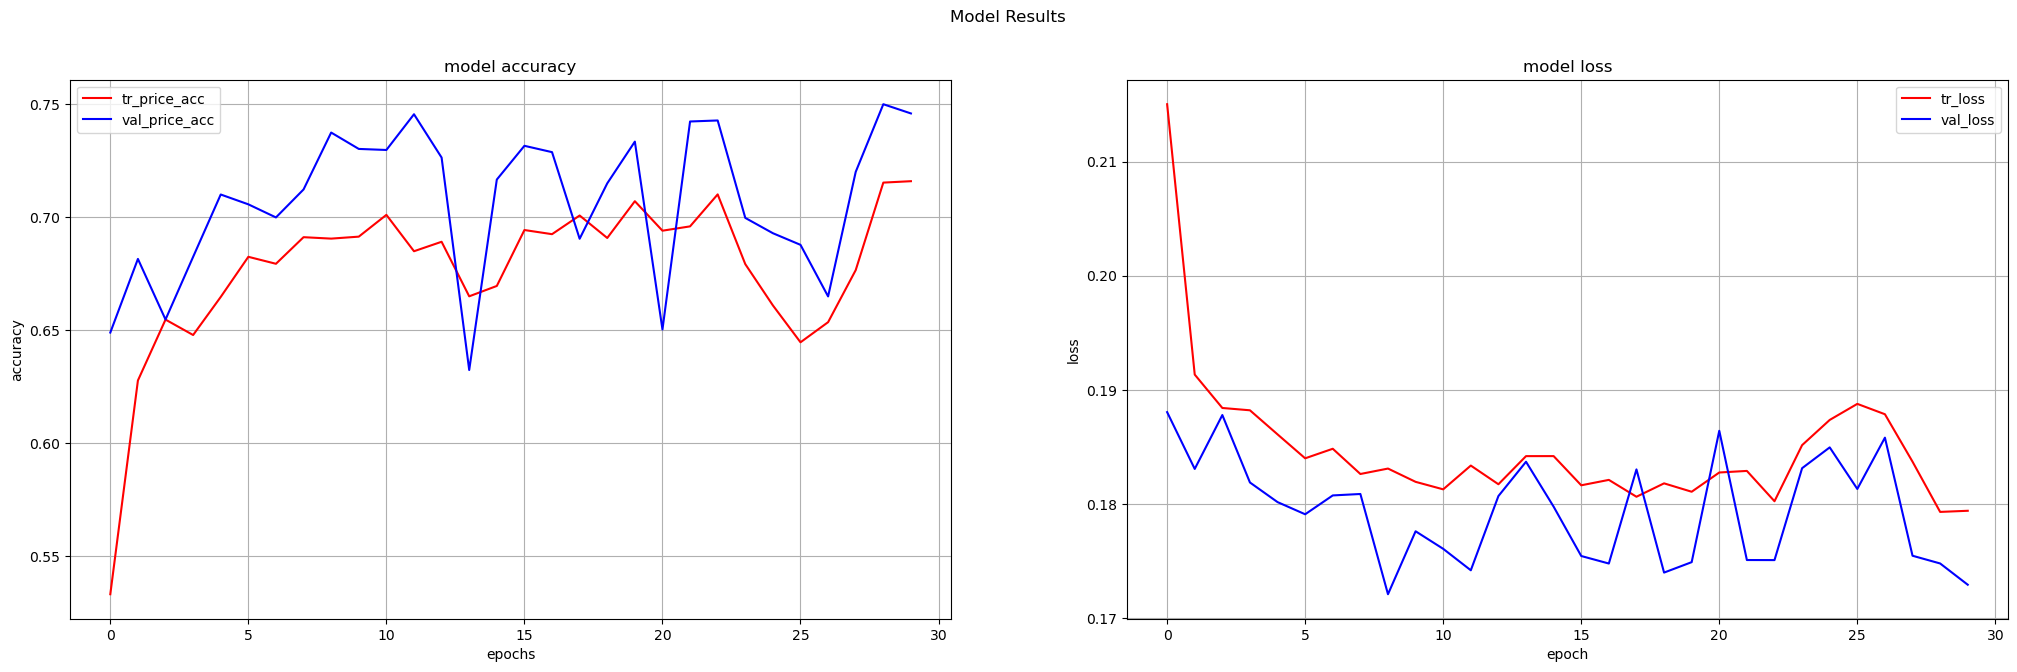

In [170]:
plot_model_history(history)

# Trial 4(No Upsampling)

- model will have 32-dimensional node embeddings, condition-aware message passing, a dropout ratio of 0.2, 12 hidden layers, message aggregation using the mean function, and an RGCN layer.

In [171]:
Model_4=GNN_model(32,True,0.2,12,'mean','rgcn')

In [172]:
summary, csv_file, history = Fit_Pred_Save(Model_4,'adam',16,30,4)

Epoch 1/30
1252/1252 [==============================] - 26s 16ms/step - loss: 0.1994 - auc: 0.5954 - val_loss: 0.1763 - val_auc: 0.7180
Epoch 2/30
1252/1252 [==============================] - 18s 14ms/step - loss: 0.1801 - auc: 0.7055 - val_loss: 0.1731 - val_auc: 0.7497
Epoch 3/30
1252/1252 [==============================] - 18s 15ms/step - loss: 0.1756 - auc: 0.7295 - val_loss: 0.1743 - val_auc: 0.7438
Epoch 4/30
1252/1252 [==============================] - 17s 14ms/step - loss: 0.1767 - auc: 0.7231 - val_loss: 0.1722 - val_auc: 0.7537
Epoch 5/30
1252/1252 [==============================] - 18s 14ms/step - loss: 0.1745 - auc: 0.7337 - val_loss: 0.1730 - val_auc: 0.7543
Epoch 6/30
1252/1252 [==============================] - 17s 14ms/step - loss: 0.1708 - auc: 0.7509 - val_loss: 0.1748 - val_auc: 0.7406
Epoch 7/30
1252/1252 [==============================] - 17s 14ms/step - loss: 0.1722 - auc: 0.7459 - val_loss: 0.1761 - val_auc: 0.7427
Epoch 8/30
1252/1252 [==========================

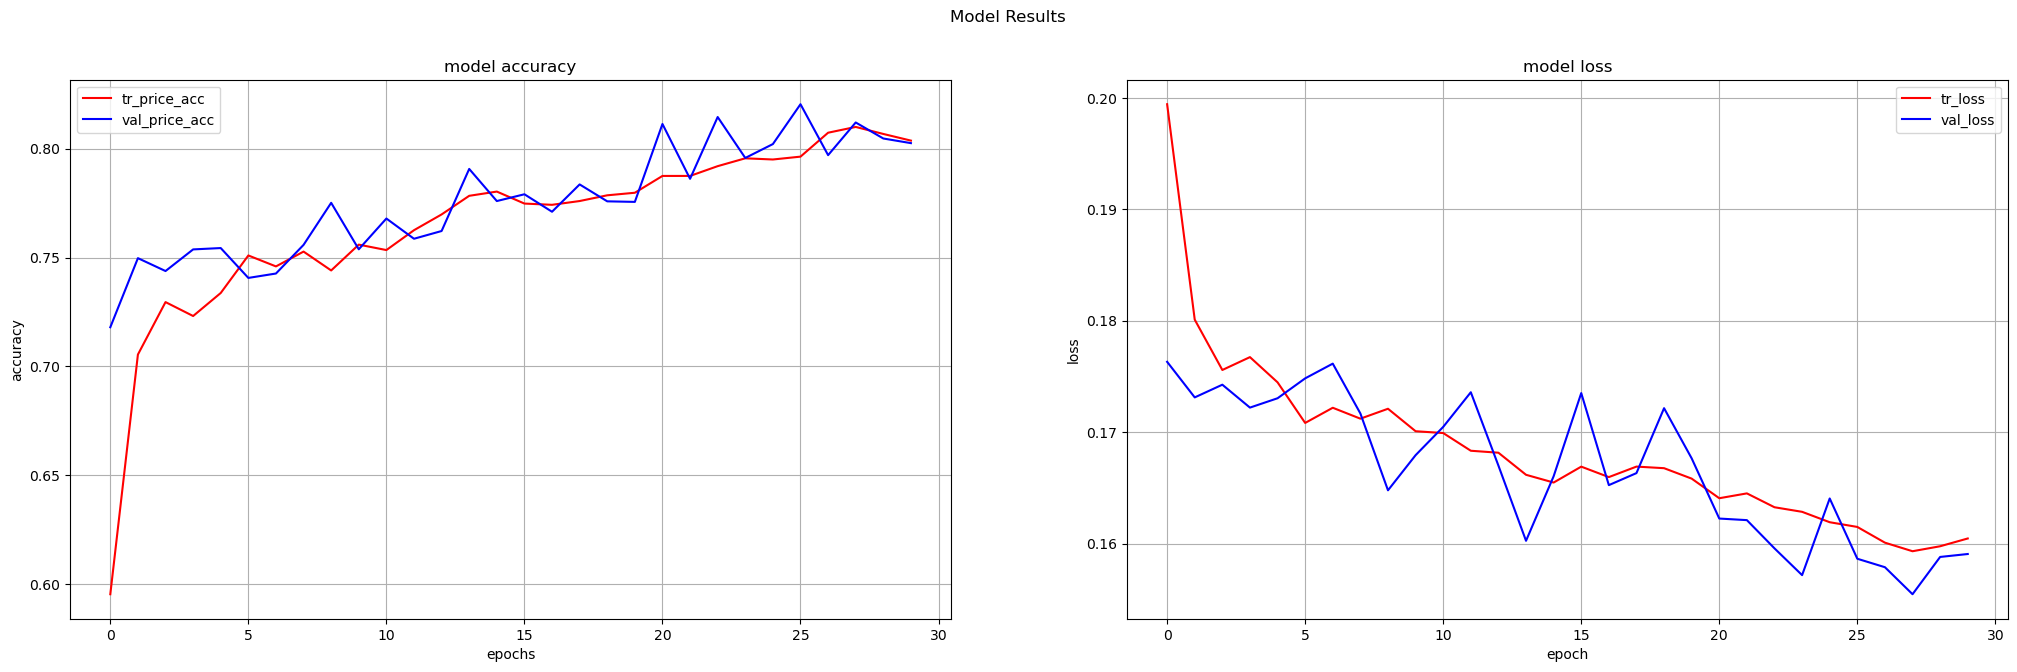

In [173]:
plot_model_history(history)

# Trial 5(No Upsampling)

- model will have 32-dimensional node embeddings, condition-aware message passing, a dropout ratio of 0.2, 12 hidden layers, message aggregation using the mean function, and a GGNN layer


In [174]:
Model_5=GNN_model(32,True,0.2,12,'mean','ggnn')

In [175]:
summary, csv_file, history = Fit_Pred_Save(Model_5,'adam',16,30,5)

Epoch 1/30
1252/1252 [==============================] - 28s 17ms/step - loss: 0.1890 - auc: 0.6355 - val_loss: 0.1838 - val_auc: 0.7015
Epoch 2/30
1252/1252 [==============================] - 20s 16ms/step - loss: 0.1804 - auc: 0.6881 - val_loss: 0.1805 - val_auc: 0.7122
Epoch 3/30
1252/1252 [==============================] - 20s 16ms/step - loss: 0.1758 - auc: 0.7155 - val_loss: 0.1951 - val_auc: 0.7366
Epoch 4/30
1252/1252 [==============================] - 21s 17ms/step - loss: 0.1732 - auc: 0.7350 - val_loss: 0.1731 - val_auc: 0.7680
Epoch 5/30
1252/1252 [==============================] - 20s 16ms/step - loss: 0.1738 - auc: 0.7240 - val_loss: 0.1692 - val_auc: 0.7692
Epoch 6/30
1252/1252 [==============================] - 21s 17ms/step - loss: 0.1692 - auc: 0.7528 - val_loss: 0.1756 - val_auc: 0.7694
Epoch 7/30
1252/1252 [==============================] - 20s 16ms/step - loss: 0.1709 - auc: 0.7432 - val_loss: 0.1785 - val_auc: 0.7524
Epoch 8/30
1252/1252 [==========================

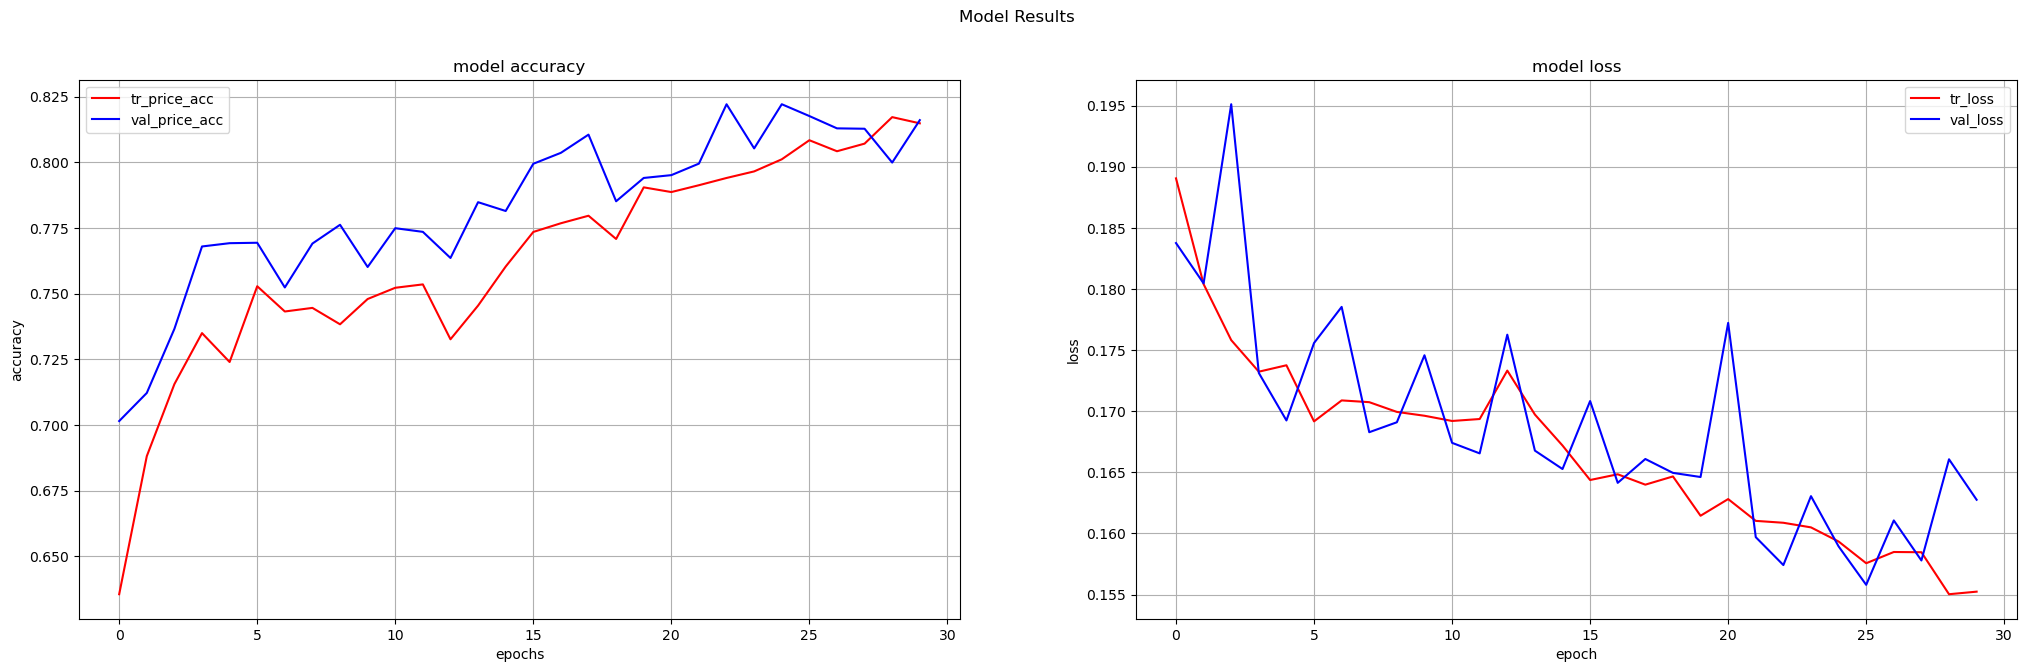

In [176]:
plot_model_history(history)

# Apply Upsampling

* Upsampling is a technique used to balance class distribution in imbalanced datasets. This method involves creating new synthetic data points for the minority class to increase its representation in the dataset. The result is a more balanced dataset, with similar numbers of instances for each class. Upsampling helps prevent models from being biased towards the majority class and can improve overall model performance.

# Data preprocessing ( _2) 

In [177]:
training_set = read_sdf('/kaggle/input/cisc873-dm-w23-a6/train.sdf')
testing_set  = read_sdf('/kaggle/input/cisc873-dm-w23-a6/test_x.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

In [178]:
# Extract the labels from the training set
labels = [sample[2] for sample in training_set]

# Count the number of occurrences of each label
label_counts = collections.Counter(labels)

# Print the count of each label
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")


Label 0: 23806 samples
Label 1: 1218 samples


In [179]:
from pandas.core.frame import DataFrame
DataFrame(np.array(training_set)) #convert to data frame to be able to split ones and zeros classes

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


,0,1,2
0,"[S, O, O, O, O, N, N, N, C, C, C, C, C, C, C, ...","[[0, 8], [0, 14], [1, 10], [2, 11], [3, 7], [4...",0
1,"[O, O, O, O, O, O, N, N, N, C, C, C, C, C, C, ...","[[0, 6], [0, 15], [1, 15], [2, 7], [3, 8], [4,...",0
2,"[F, F, F, O, O, O, O, O, N, N, C, C, C, C, C, ...","[[0, 19], [1, 19], [2, 19], [3, 16], [4, 28], ...",0
3,"[Cl, S, S, O, O, O, O, N, N, N, N, C, C, C, C,...","[[0, 12], [1, 15], [1, 18], [2, 4], [2, 5], [2...",0
4,"[S, O, O, N, N, N, N, N, N, C, C, C, C, C, C, ...","[[0, 1], [0, 2], [0, 5], [0, 9], [3, 4], [3, 1...",0
...,...,...,...
25019,"[O, O, O, O, O, O, N, N, C, C, C, C, C, C, C, ...","[[0, 8], [0, 14], [1, 10], [2, 12], [3, 13], [...",0
25020,"[O, O, O, O, O, N, C, C, C, C, C, C, C, C, C, ...","[[0, 9], [1, 11], [2, 16], [2, 19], [3, 16], [...",0
25021,"[O, O, O, O, O, O, O, O, O, N, C, C, C, C, C, ...","[[0, 12], [0, 16], [1, 10], [2, 11], [3, 15], ...",0
25022,"[S, O, O, O, O, N, N, N, C, C, C, C, C, C, C, ...","[[0, 11], [0, 12], [1, 21], [1, 27], [2, 22], ...",0


In [180]:
DataFrame(np.array(training_set)).rename(columns = {0:'nodes', 1:'edges',2:'label'}, inplace = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [182]:
X_train = pd.DataFrame(np.array(training_set)[:,:-1])
y_train = pd.DataFrame(np.array(training_set)[:,2])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [183]:
from sklearn.utils import resample
resampling = X_train.copy()
resampling[2] = y_train.values
class_0 = resampling[resampling[2]==0]
class_1 = resampling[resampling[2]==1]
class_1_after = resample(class_1, replace=True,n_samples=23806)
df_upsampled = pd.concat([class_0, class_1_after])

In [184]:
# Display new class counts
df_upsampled[2].value_counts()

0    23806
1    23806
Name: 2, dtype: int64

In [186]:
training_set = df_upsampled.values.tolist() # to return data from dataframe to arry

In [187]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break

data
[5 5 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 7 7 7 2 2 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 5 4 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0]
edges
[[  0  11]
 [  1  16]
 [  2   8]
 [  3   4]
 [  3   5]
 [  4   9]
 [  5   6]
 [  5   8]
 [  6   7]
 [  6  12]
 [  7  10]
 [  7  14]
 [  8  13]
 [  9  11]
 [  9  15]
 [ 10  13]
 [ 11  17]
 [ 12  18]
 [ 14  20]
 [ 15  16]
 [ 16  19]
 [ 17  19]
 [ 18  20]
 [ 29  37]
 [ 30  37]
 [ 31  37]
 [ 32  41]
 [ 32  46]
 [ 33  46]
 [ 34  35]
 [ 34  38]
 [ 35  36]
 [ 35  37]
 [ 36  40]
 [ 36  41]
 [ 38  39]
 [ 38  42]
 [ 39  40]
 [ 39  43]
 [ 42  44]
 [ 43  45]
 [ 44  45]
 [ 46  47]
 [ 58  76]
 [ 58  82]
 [ 59  64]
 [ 59  67]
 [ 59  71]
 [ 60  69]
 [ 60  71]
 [ 61  70]
 [ 61  77]
 [ 61  80]
 [ 62  66]
 [ 62  79]
 [ 63  81]
 [ 63  83]
 [ 63  84]
 [ 64  65]
 [ 64  69]
 [ 65  66]
 [ 65  70]
 [ 66  68]
 [ 67  68]
 [ 67  75]
 [ 68  74]
 [ 69  72]
 [ 70  73]
 [ 7

# Trial 6(Apply Upsampling)

- calling a GNN model with the following specifications: 32 nodes in each layer, using Gated Graph Neural Networks (GGNN) mechanism, 12 hidden layers, mean pooling mode, and dropout ratio of 0. 

In [188]:
Model_6=GNN_model(32,True,0,12,'mean','GGNN')

In [189]:
summary, csv_file, history = Fit_Pred_Save(Model_6,'adam',16,28,6)

Epoch 1/28
2976/2976 [==============================] - 53s 15ms/step - loss: 0.5659 - auc: 0.7776 - val_loss: 0.4825 - val_auc: 0.8602
Epoch 2/28
2976/2976 [==============================] - 45s 15ms/step - loss: 0.4702 - auc: 0.8582 - val_loss: 0.5178 - val_auc: 0.8854
Epoch 3/28
2976/2976 [==============================] - 44s 15ms/step - loss: 0.4179 - auc: 0.8903 - val_loss: 0.5610 - val_auc: 0.9142
Epoch 4/28
2976/2976 [==============================] - 43s 14ms/step - loss: 0.3790 - auc: 0.9104 - val_loss: 0.4333 - val_auc: 0.9336
Epoch 5/28
2976/2976 [==============================] - 43s 14ms/step - loss: 0.3483 - auc: 0.9243 - val_loss: 0.4285 - val_auc: 0.9436
Epoch 6/28
2976/2976 [==============================] - 44s 15ms/step - loss: 0.3258 - auc: 0.9336 - val_loss: 0.3381 - val_auc: 0.9491
Epoch 7/28
2976/2976 [==============================] - 43s 14ms/step - loss: 0.3063 - auc: 0.9407 - val_loss: 0.3285 - val_auc: 0.9610
Epoch 8/28
2976/2976 [==========================

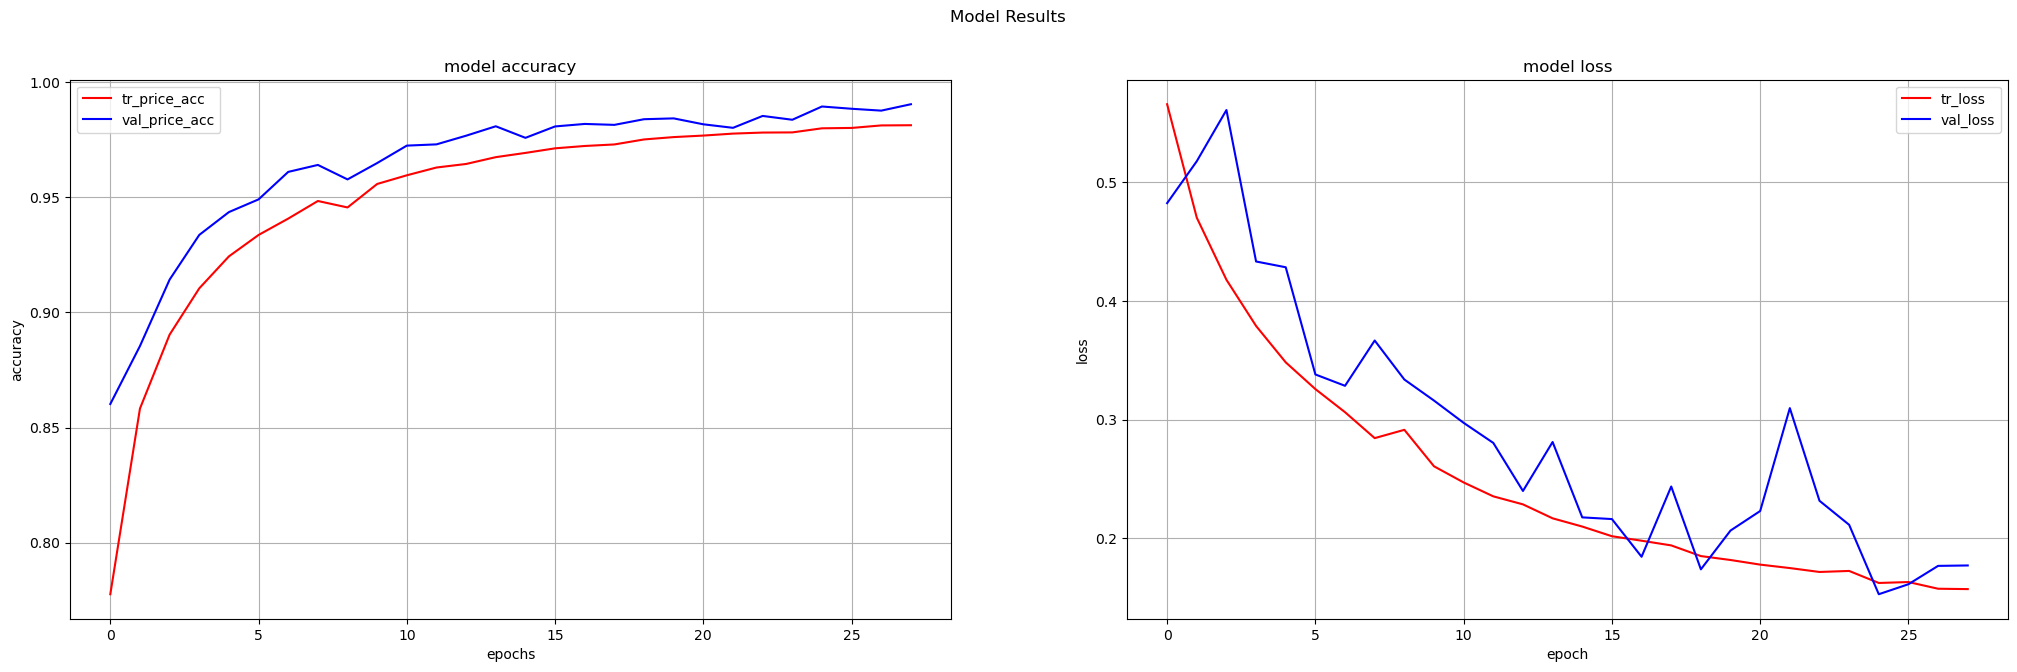

In [190]:
plot_model_history(history)

# Trial 7(Apply Upsampling)

- The GNN_model function is being called with several arguments including n=32, condition=True, dropout_ratio=0.1, hidden_layers=12, mode='mean', and par='gnn_edge_mlp' which corresponds to the Graph Neural Networks-Edge classification mechanism.

In [191]:
Model_7=GNN_model(32,True,0.1,12,'mean','gnn_edge_mlp')

In [192]:
summary, csv_file, history = Fit_Pred_Save(Model_7,'adam',32,18,7)

Epoch 1/18
1488/1488 [==============================] - 28s 16ms/step - loss: 0.5960 - auc: 0.7427 - val_loss: 0.7791 - val_auc: 0.7936
Epoch 2/18
1488/1488 [==============================] - 21s 14ms/step - loss: 0.5410 - auc: 0.8019 - val_loss: 0.7286 - val_auc: 0.8261
Epoch 3/18
1488/1488 [==============================] - 20s 14ms/step - loss: 0.5121 - auc: 0.8270 - val_loss: 0.5938 - val_auc: 0.8289
Epoch 4/18
1488/1488 [==============================] - 21s 14ms/step - loss: 0.4896 - auc: 0.8439 - val_loss: 0.5062 - val_auc: 0.8787
Epoch 5/18
1488/1488 [==============================] - 21s 14ms/step - loss: 0.4704 - auc: 0.8575 - val_loss: 0.3391 - val_auc: 0.8991
Epoch 6/18
1488/1488 [==============================] - 21s 14ms/step - loss: 0.4561 - auc: 0.8672 - val_loss: 0.5315 - val_auc: 0.8774
Epoch 7/18
1488/1488 [==============================] - 21s 14ms/step - loss: 0.4399 - auc: 0.8774 - val_loss: 0.5425 - val_auc: 0.9087
Epoch 8/18
1488/1488 [==========================

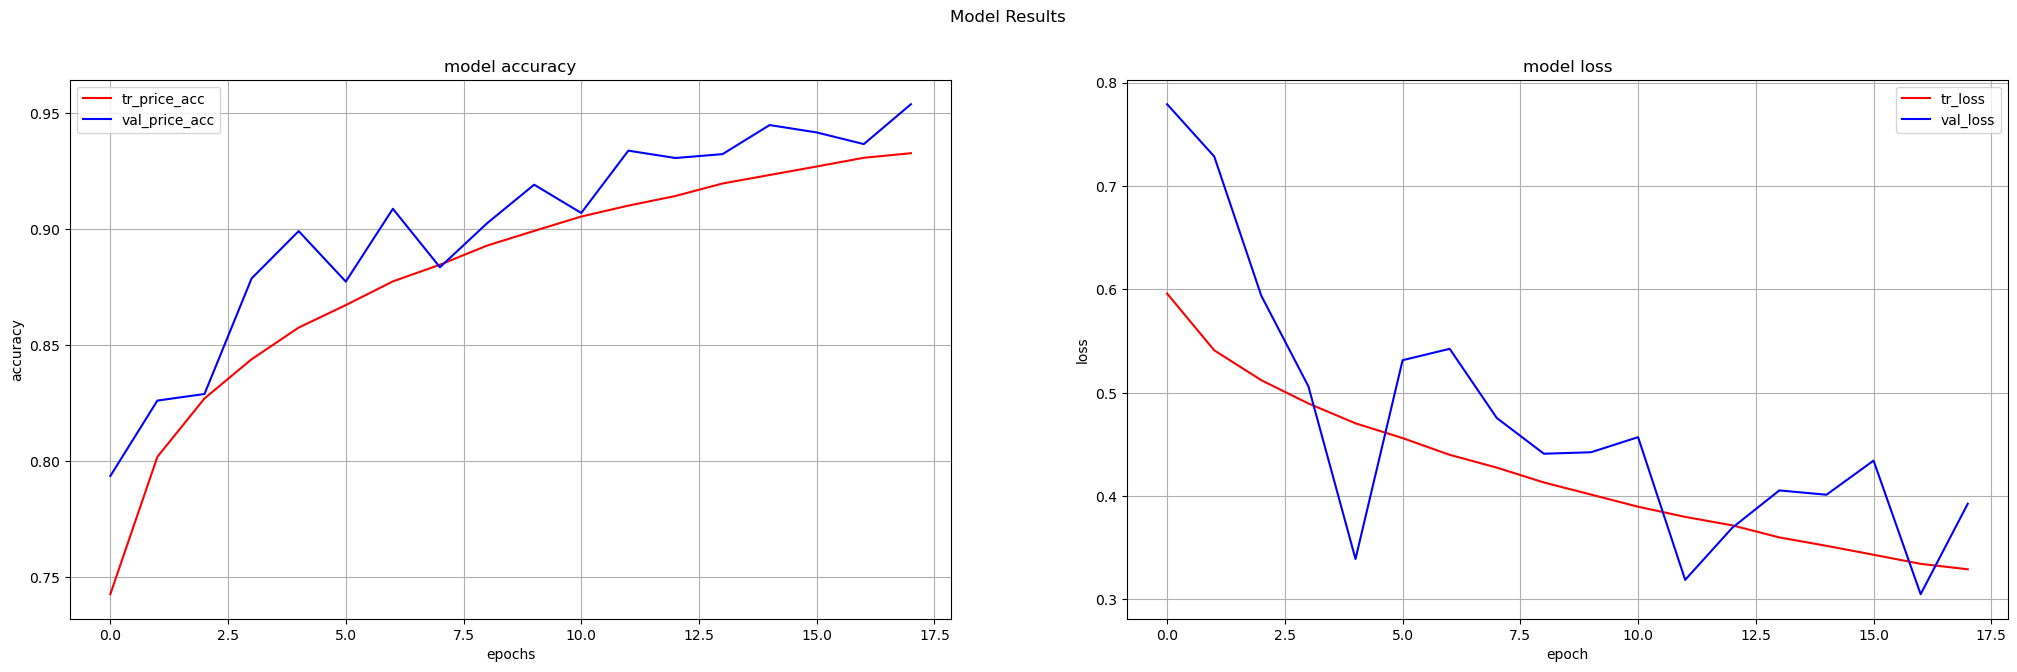

In [193]:
plot_model_history(history)

# Trial 8(Apply Upsampling)

- The GNN model is called with 4 hidden layers, using the mean aggregation method and implementing Graph Neural Networks with Feature-wise Linear Modulation.

In [197]:
# defines a function named GNN_model that takes in six parameters: n, condition, dropout_ratio, hidden_layers, mode, and par.
def GNN_model_Film(n, condition, dropout_ratio, hidden_layers, mode, par):
# Define input layers
    data = keras.Input(batch_shape=(None,))  # Node features
    edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)  # Edge indices (2D)
    node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)  # Node-to-graph mapping
# Embed the input data
    embeded = Embedding(tokenizer.num_words, 100)(data)
# Compute the number of graphs (i.e., number of samples)
    num_graph = tf.reduce_max(node2graph) + 1
# Define the input to the GNN layer
    gnn_input = GNNInput(
        node_features=embeded,#The node_features parameter specifies the embedded node features
        adjacency_lists=(edge,),#the adjacency_lists parameter specifies the edge indices
        node_to_graph_map=node2graph,#the node_to_graph_map parameter specifies the node-to-graph mapping
        num_graphs=num_graph, #the num_graphs parameter specifies the number of graphs in the input batch.
    )
# Set hyperparameters for the GNN layer
    params = GNN.get_default_hyperparameters()
    params["hidden_dim"] = n  # Hidden dimension of the GNN layer
    params["num_heads"] = 8
    params["dense_every_num_layers"] = 2
    params["use_inter_layer_layernorm"] = condition  # Use inter-layer layer normalization
    params["num_layers"] = 4
    params["layer_input_dropout_rate"] = dropout_ratio  # Dropout rate for the input to each layer
    params['num_aggr_MLP_hidden_layers'] = hidden_layers  # Number of hidden layers in the MLP used for message aggregation
    params["num_edge_MLP_hidden_layers"] = 2
    params["global_exchange_mode"] = mode  # Global exchange mode
    params['message_calculation_class'] = par  # Message calculation method
    params["film_parameter_MLP_hidden_layers"] = 2
# Create the GNN layer and apply it to the input
    gnn_layer = GNN(params)        #GNN layer with the specified hyperparameters.
    gnn_out = gnn_layer(gnn_input) #applies the GNN layer to the input to obtain graph-level embeddings.
# computes the mean of the graph-level embeddings, where each graph is identified by its corresponding value in node2graph.
    avg = segment_mean(
        data=gnn_out,
        segment_ids=node2graph
    )
# Define the fully connected layers for classification
    l1 = Dense(64, activation='relu')(avg)
    l2 = Dense(64, activation='relu')(l1)
    pred = Dense(1, activation='sigmoid')(l2)
# Define the model with inputs and outputs
    model = Model(
        inputs={
            'data': data,
            'edges': edge,
            'node2graph': node2graph,
        },
        outputs=pred
    )
    return model

In [198]:
Model_8=GNN_model_Film(32,True,0,4,'mean','GNN_FiLM')

In [199]:
summary, csv_file, history = Fit_Pred_Save(Model_8,'adam',16,25,8)

Epoch 1/25
2976/2976 [==============================] - 54s 15ms/step - loss: 0.6316 - auc: 0.6898 - val_loss: 0.7275 - val_auc: 0.7346
Epoch 2/25
2976/2976 [==============================] - 46s 15ms/step - loss: 0.5791 - auc: 0.7614 - val_loss: 0.5400 - val_auc: 0.8028
Epoch 3/25
2976/2976 [==============================] - 45s 15ms/step - loss: 0.5487 - auc: 0.7935 - val_loss: 0.5071 - val_auc: 0.8057
Epoch 4/25
2976/2976 [==============================] - 45s 15ms/step - loss: 0.5340 - auc: 0.8073 - val_loss: 0.5289 - val_auc: 0.8260
Epoch 5/25
2976/2976 [==============================] - 46s 15ms/step - loss: 0.5228 - auc: 0.8170 - val_loss: 0.4545 - val_auc: 0.8282
Epoch 6/25
2976/2976 [==============================] - 45s 15ms/step - loss: 0.4826 - auc: 0.8491 - val_loss: 0.4540 - val_auc: 0.8664
Epoch 7/25
2976/2976 [==============================] - 44s 15ms/step - loss: 0.4534 - auc: 0.8688 - val_loss: 0.4791 - val_auc: 0.8728
Epoch 8/25
2976/2976 [==========================

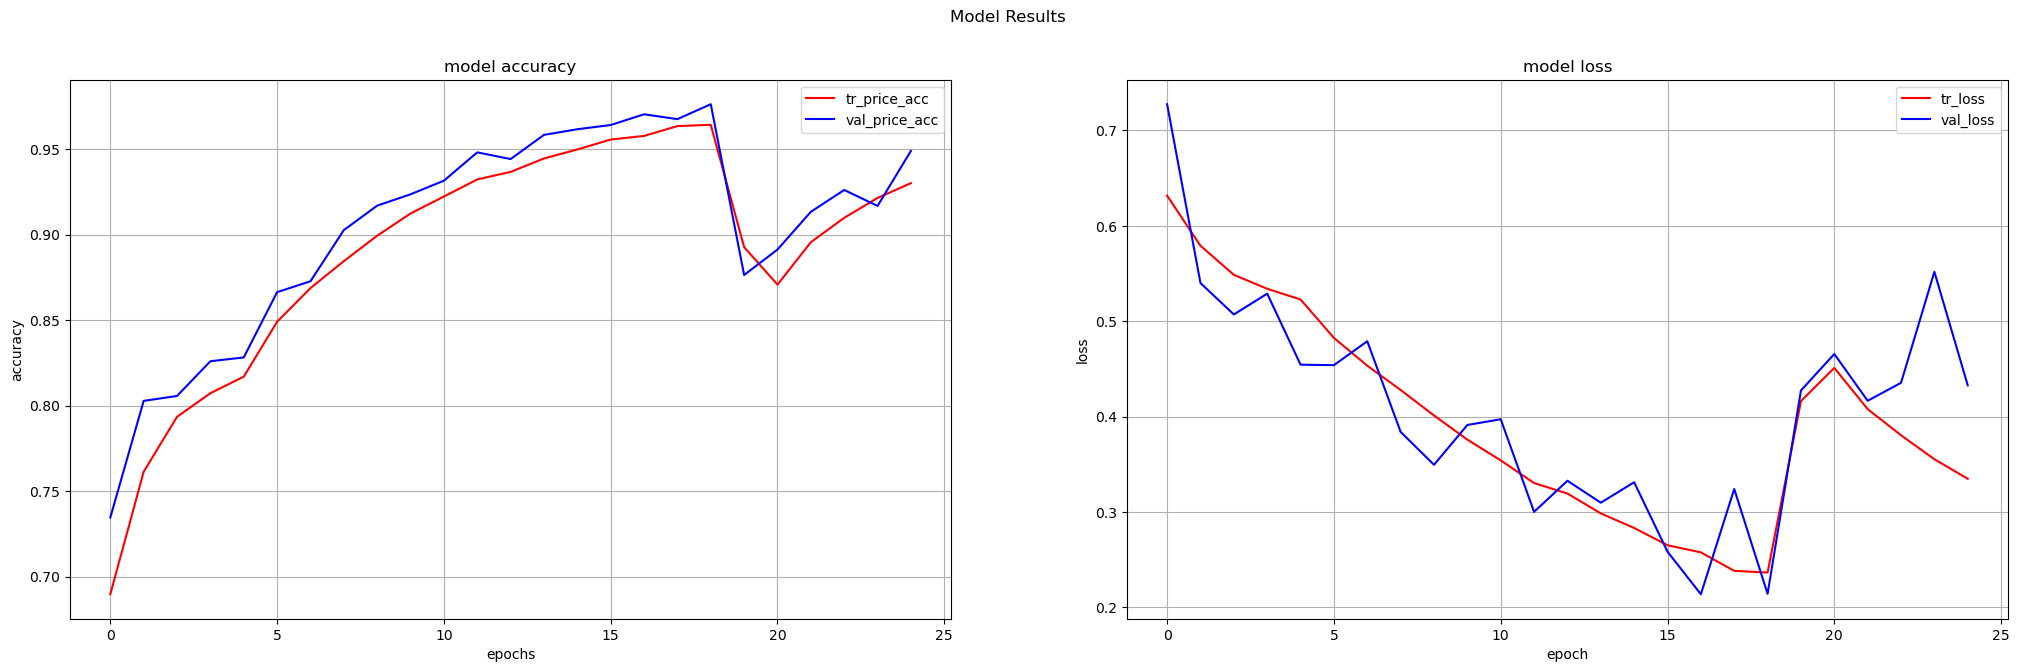

In [200]:
plot_model_history(history)

# Trial 9(Apply Upsampling)

- The GNN model is using 15 hidden layers and employs the relation-aware Graph Attention Networks mechanism (RGAT) for better modeling of relationships between nodes in the graph. The 'mean' mode is used to aggregate node features.

In [201]:
Model_9=GNN_model(32,True,0,15,'mean','RGAT')

In [202]:
summary, csv_file, history = Fit_Pred_Save(Model_9,'adam',16,25,9)

Epoch 1/25
2976/2976 [==============================] - 105s 32ms/step - loss: 0.5710 - auc: 0.7729 - val_loss: 0.6592 - val_auc: 0.8161
Epoch 2/25
2976/2976 [==============================] - 94s 32ms/step - loss: 0.5075 - auc: 0.8295 - val_loss: 0.5298 - val_auc: 0.8644
Epoch 3/25
2976/2976 [==============================] - 94s 32ms/step - loss: 0.4656 - auc: 0.8608 - val_loss: 0.4375 - val_auc: 0.8850
Epoch 4/25
2976/2976 [==============================] - 95s 32ms/step - loss: 0.4250 - auc: 0.8865 - val_loss: 0.3936 - val_auc: 0.9041
Epoch 5/25
2976/2976 [==============================] - 95s 32ms/step - loss: 0.3939 - auc: 0.9032 - val_loss: 0.3291 - val_auc: 0.9267
Epoch 6/25
2976/2976 [==============================] - 94s 32ms/step - loss: 0.3688 - auc: 0.9153 - val_loss: 0.5317 - val_auc: 0.9378
Epoch 7/25
2976/2976 [==============================] - 94s 32ms/step - loss: 0.3429 - auc: 0.9269 - val_loss: 0.2974 - val_auc: 0.9302
Epoch 8/25
2976/2976 [=========================

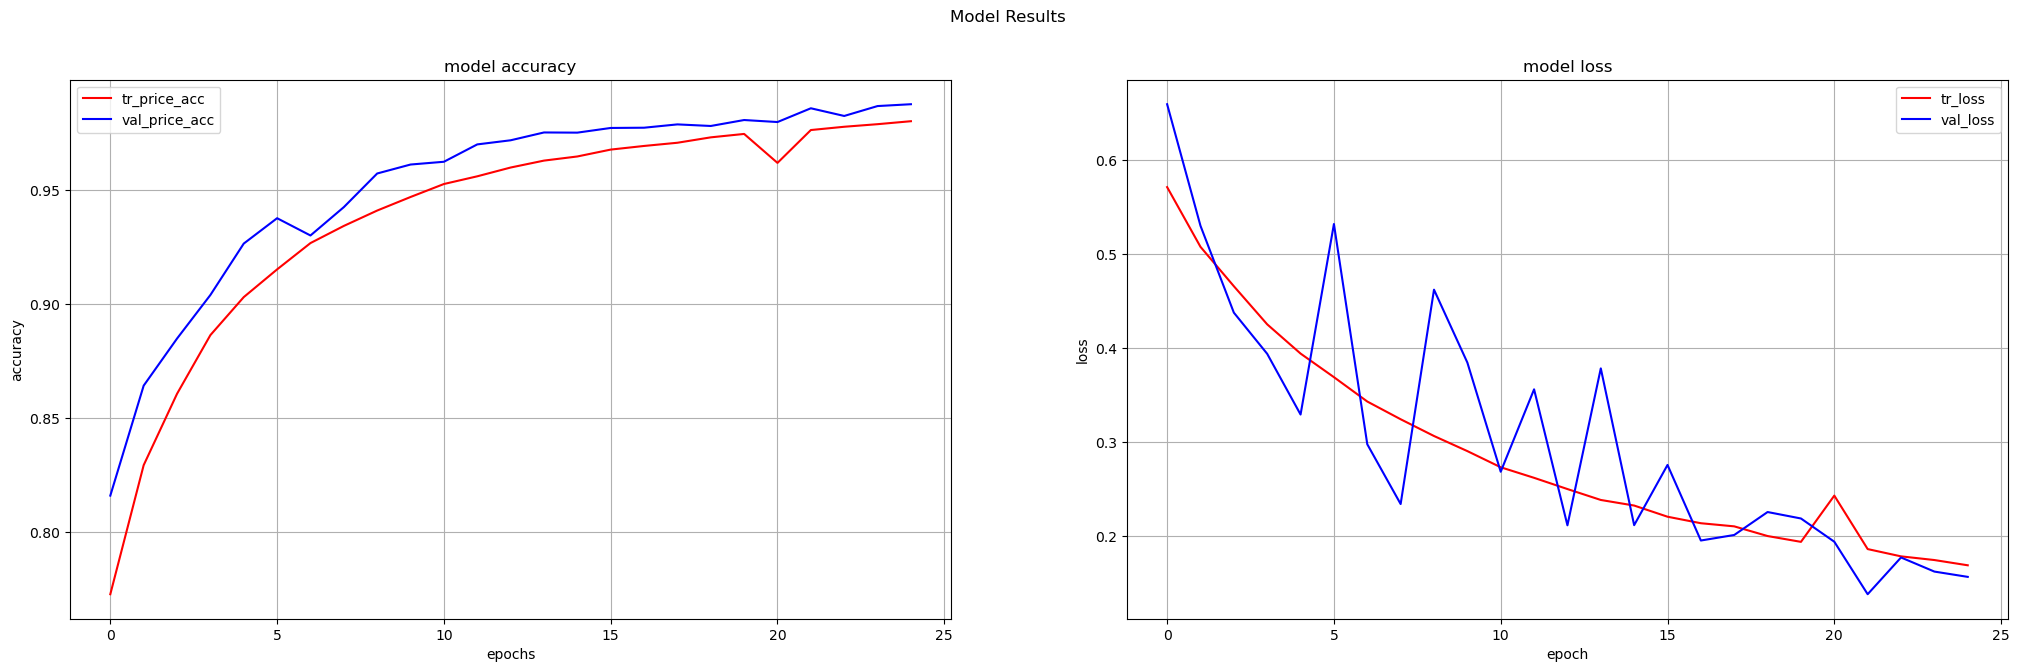

In [203]:
plot_model_history(history)

# Trial 10(Apply Upsampling)

- The GNN model is being called with the argument configuration to use a Gated Graph Neural Networks mechanism with 12 hidden layers and a GRU-based update mode, with node embedding size of 36 and no dropout.

In [204]:
Model_10=GNN_model(36,True,0,12,'gru','ggnn')

In [205]:
summary, csv_file, history = Fit_Pred_Save(Model_10,'adam',16,28,10)

Epoch 1/28
2976/2976 [==============================] - 53s 15ms/step - loss: 0.5601 - auc: 0.7827 - val_loss: 0.4991 - val_auc: 0.8557
Epoch 2/28
2976/2976 [==============================] - 46s 15ms/step - loss: 0.4688 - auc: 0.8593 - val_loss: 0.4343 - val_auc: 0.8845
Epoch 3/28
2976/2976 [==============================] - 44s 15ms/step - loss: 0.4216 - auc: 0.8884 - val_loss: 0.5109 - val_auc: 0.9218
Epoch 4/28
2976/2976 [==============================] - 45s 15ms/step - loss: 0.3752 - auc: 0.9120 - val_loss: 0.3331 - val_auc: 0.9326
Epoch 5/28
2976/2976 [==============================] - 45s 15ms/step - loss: 0.3300 - auc: 0.9315 - val_loss: 0.3288 - val_auc: 0.9513
Epoch 6/28
2976/2976 [==============================] - 44s 15ms/step - loss: 0.2989 - auc: 0.9426 - val_loss: 0.3992 - val_auc: 0.9538
Epoch 7/28
2976/2976 [==============================] - 45s 15ms/step - loss: 0.2735 - auc: 0.9510 - val_loss: 0.2687 - val_auc: 0.9622
Epoch 8/28
2976/2976 [==========================

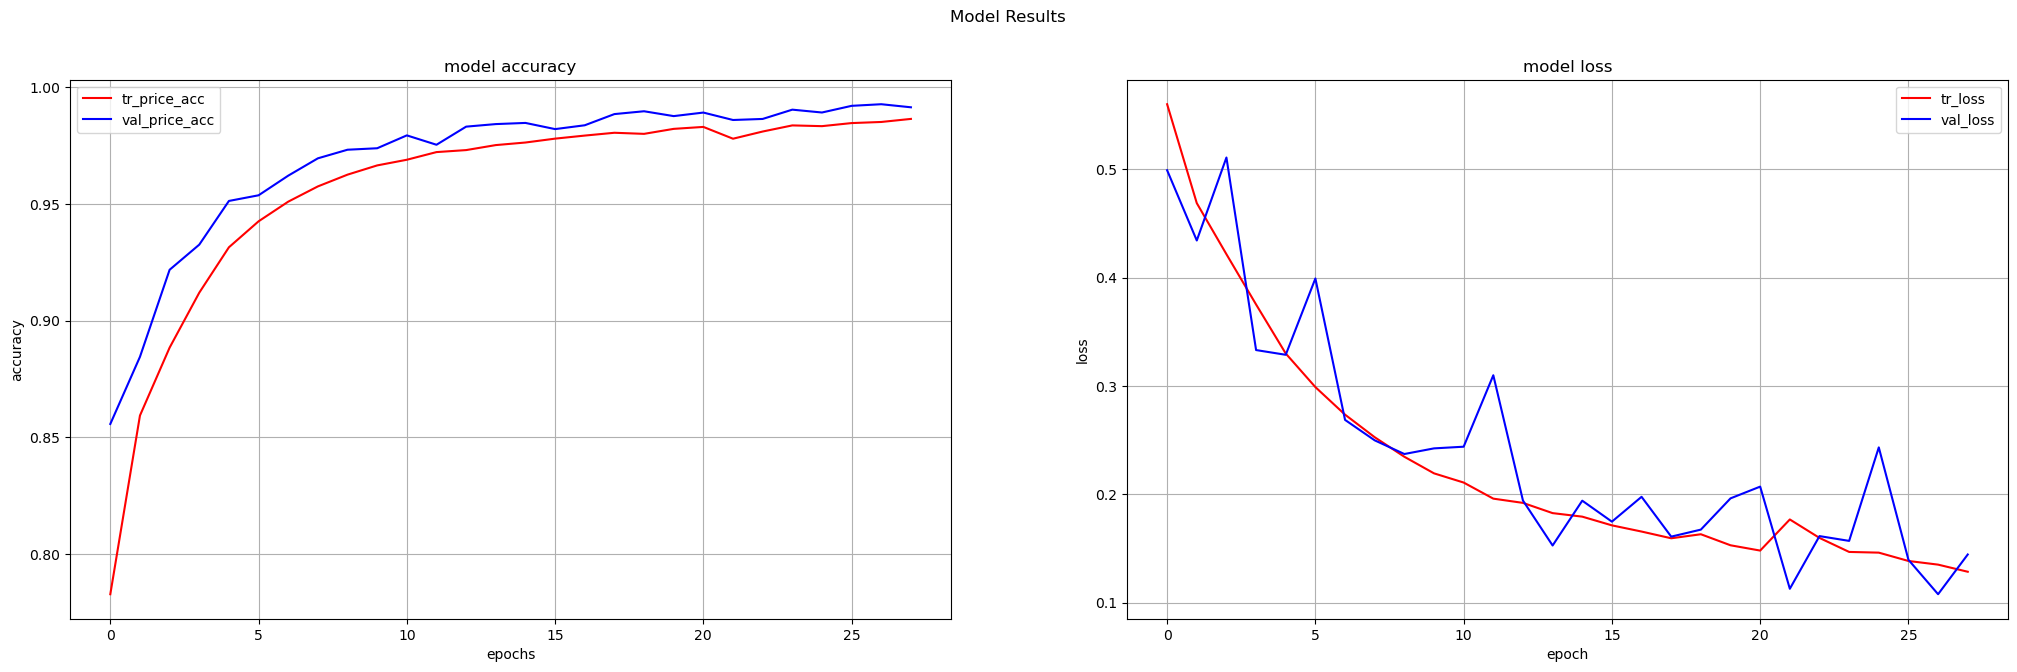

In [206]:
plot_model_history(history)